```{raw} jupyter
<div id="qe-notebook-header" align="right" style="text-align:right;">
        <a href="https://quantecon.org/" title="quantecon.org">
                <img style="width:250px;display:inline;" width="250px" src="https://assets.quantecon.org/img/qe-menubar-logo.svg" alt="QuantEcon">
        </a>
</div>
```

# Kesten过程与企业动态

```{index} single: Linear State Space Models
```

```{contents} Contents
:depth: 2
```

除了Anaconda中包含的内容外，本讲座还需要以下库：

In [1]:
!pip install quantecon
!pip install --upgrade yfinance

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/3.0 MB ? eta -:--:--

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 97.3 MB/s eta 0:00:00


  Installing build dependencies ... -

 \

 |

 done


  Getting requirements to build wheel ... -

 done


  Preparing metadata (pyproject.toml) ... -

 done


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/8.5 MB ? eta -:--:--

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.5/8.5 MB 160.2 MB/s eta 0:00:00


 \

 |

 done
  Created wheel for peewee: filename=peewee-3.18.1-cp312-cp312-linux_x86_64.whl size=303844 sha256=200b295899b83dc884ecf9b41531021fb6f91b2f98d558c05a6dc62cdf346b84
  Stored in directory: /home/runner/.cache/pip/wheels/1a/57/6a/bb71346381d0d911cd4ce3026f1fa720da76707e4f01cf27dd
Successfully built peewee


## 概述

{doc}`之前 <intro:ar1_processes>` 我们学习了线性标量值随机过程（AR(1)模型）。

现在，我们将进一步推广这些线性模型，允许乘法系数具有随机性。

这些过程被称为Kesten过程，以德裔美国数学家Harry Kesten（1931-2019）的名字命名。

虽然Kesten过程的数学形式看起来很简单，但它们在经济学中非常重要，主要有两个原因：

1. 很多关键的经济过程可以用Kesten过程来描述。
2. Kesten过程能够产生复杂的动态行为，尤其是在某些条件下，它们可以生成带有"重尾"特征的横截面分布，这与我们在现实经济数据中观察到的情况相符。

我们接下来会讨论这些问题。

现在我们从一些导入开始：

In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl
FONTPATH = "fonts/SourceHanSerifSC-SemiBold.otf"
mpl.font_manager.fontManager.addfont(FONTPATH)
plt.rcParams['font.family'] = ['Source Han Serif SC']

plt.rcParams["figure.figsize"] = (11, 5)  #设置默认图形大小
import numpy as np
import quantecon as qe

以下两行仅用于避免pandas和matplotlib之间的兼容性问题导致的`FutureWarning`。

In [3]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

关于本讲座的更多技术细节，读者可以参考{cite}`buraczewski2016stochastic`这本专著。

## Kesten过程

```{index} single: Kesten processes; heavy tails
```

**Kesten过程**是一种形式如下的随机过程：

```{math}
:label: kesproc

X_{t+1} = a_{t+1} X_t + \eta_{t+1}
```

其中$\{a_t\}_{t \geq 1}$和$\{\eta_t\}_{t \geq 1}$是独立同分布序列。

我们感兴趣的是当$X_0$给定时$\{X_t\}_{t \geq 0}$的动态变化。

我们将重点关注非负标量的情况，其中$X_t$的取值范围为$\mathbb R_+$。

特别地，我们假设：

* 初始条件$X_0$是非负的，
* $\{a_t\}_{t \geq 1}$是非负的独立同分布随机过程，且
* $\{\eta_t\}_{t \geq 1}$是另一个非负的独立同分布随机过程，并与第一个过程相互独立。

### 示例：GARCH波动率

GARCH模型在金融应用中很常见，其中时间序列（如资产收益）表现出时变波动率。

例如，考虑以下纳斯达克综合指数从2006年1月1日到2019年11月1日的日收益率图。

(ndcode)=

[*********************100%***********************]  1 of 1 completed

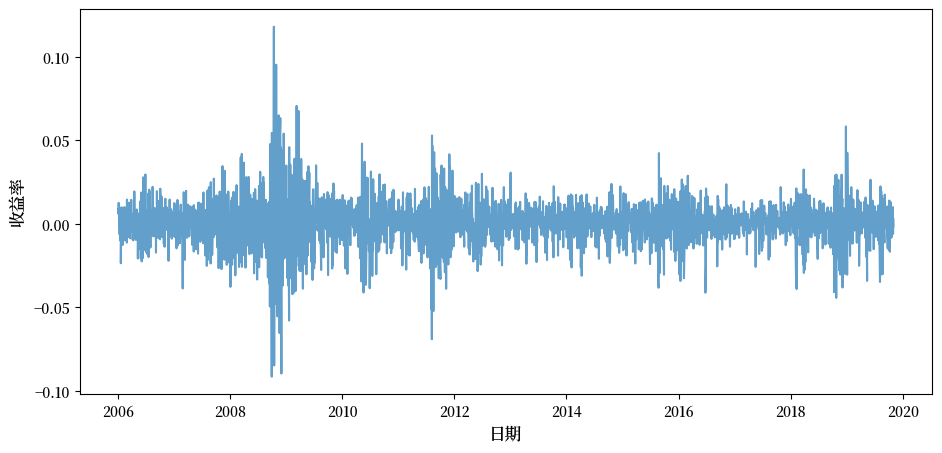

In [4]:
import yfinance as yf

s = yf.download('^IXIC', '2006-1-1', '2019-11-1', auto_adjust=False)['Adj Close']

r = s.pct_change()

fig, ax = plt.subplots()

ax.plot(r, alpha=0.7)

ax.set_ylabel('收益率', fontsize=12)
ax.set_xlabel('日期', fontsize=12)

plt.show()

注意该序列如何呈现出波动率爆发（高方差），随后又趋于平稳。

GARCH模型可以复现这一特征。

GARCH(1, 1)波动率过程的形式如下：

```{math}
:label: garch11v

\sigma_{t+1}^2 = \alpha_0 + \sigma_t^2 (\alpha_1 \xi_{t+1}^2 + \beta)
```

其中$\{\xi_t\}$是独立同分布的，$\mathbb E \xi_t^2 = 1$且所有参数都是正的。

给定资产的收益率可建模为：

```{math}
:label: garch11r

r_t = \sigma_t \zeta_t
```

其中$\{\zeta_t\}$也是独立同分布的，且与$\{\xi_t\}$相互独立。

驱动收益率动态变化的波动率序列$\{\sigma_t^2 \}$是一个Kesten过程。

### 示例：财富动态

假设某个家庭在每一期都将其当前财富按固定比例$s$进行储蓄。

该家庭在时期$t$开始时获得劳动收入$y_t$。

其财富则按照以下方式演化：

```{math}
:label: wealth_dynam

w_{t+1} = R_{t+1} s w_t  + y_{t+1}
```

其中$\{R_t\}$是资产的总收益率。

如果$\{R_t\}$和$\{y_t\}$都是独立同分布的，那么{eq}`wealth_dynam`就是一个Kesten过程。

### 平稳性

在之前的讲座中，如{doc}`AR(1)过程 <intro:ar1_processes>`，我们引入了平稳分布的概念。

在当前背景下，我们可以这样定义一个平稳分布：

对于Kesten过程{eq}`kesproc`，若满足

```{math}
:label: kp_stationary0

X_t \sim F^*
\quad \implies \quad
a_{t+1} X_t + \eta_{t+1} \sim F^*
```

则定义在$\mathbb R$上的分布$F^*$被称为该过程的**平稳分布**。

换句话说，如果当前状态$X_t$服从分布$F^*$，那么下一期状态$X_{t+1}$也服从相同的分布$F^*$。

我们可以将其等价写为：

```{math}
:label: kp_stationary

F^*(y) = \int \mathbb P\{ a_{t+1} x + \eta_{t+1} \leq y\} F^*(dx)
\quad \text{对所有 } y \geq 0 \text{成立 }
```

式子左边是当前状态服从$F^*$时，下一期状态的分布。

{eq}`kp_stationary`这一等式表明这个分布保持不变。

### 横截面解释

平稳分布具有重要的横截面解释，之前我们已经讨论过，但仍值得在这里重复。

例如，假设我们对财富分布（某个国家当前家庭财富的分布）感兴趣。

进一步的假设：

* 每个家庭的财富根据{eq}`wealth_dynam`独立演化；
* $F^*$是这个随机过程的平稳分布；
* 存在大量家庭。

那么，$F^*$就是这个国家横截面财富分布的稳态。

换句话说，如果$F^*$是当前的财富分布，则在*其他条件不变*的情况下，其在后续时期将保持这一分布不变。

要理解这一点，假设$F^*$是当前的财富分布。

下一期财富小于$y$的家庭比例是多少？

为了得到这一比例，我们对明天的财富小于$y$的概率进行求和，给定条件为当前财富为$w$，按拥有财富$w$的家庭比例进行加权。

注意到财富在区间$dw$中的家庭比例是$F^*(dw)$，我们得到：

$$
\int \mathbb P\{ R_{t+1} s w  + y_{t+1} \leq y\} F^*(dw)
$$

根据平稳性的定义和$F^*$是财富过程的平稳分布的假设，上述积分结果为$F^*(y)$。

因此，下一期中财富在$[0, y]$内的家庭比例与当前期相同。

由于$y$是任意选择的，财富分布保持不变。

### 平稳性条件

Kesten过程$X_{t+1} = a_{t+1} X_t + \eta_{t+1}$并不总是具有平稳分布。

例如，如果对所有$t$都有$a_t \equiv \eta_t \equiv 1$，那么$X_t = X_0 + t$，此时序列会发散到无穷大。

为了防止这种发散，我们要求$\{a_t\}$在大多数情况下严格小于1。

特别地，如果：

```{math}
:label: kp_stat_cond

\mathbb E \ln a_t < 0
\quad \text{且} \quad
\mathbb E \eta_t < \infty
```

那么在$\mathbb R_+$上存在唯一的平稳分布。

* 参见，例如，{cite}`buraczewski2016stochastic`的定理2.1.3提供了稍弱的条件。

作为这个结果的一个应用，我们看到，只要劳动收入具有有限均值且满足$\mathbb E \ln R_t  + \ln s < 0$，财富过程{eq}`wealth_dynam`就会有唯一的平稳分布。

## 重尾

在某些条件下，Kesten过程的平稳分布具有帕累托尾。

（参见我们{doc}`之前关于重尾分布的讲座 <intro:heavy_tails>`。）

这个事实对经济学很重要，因为帕累托尾分布在经济现象中广泛存在。

### Kesten--Goldie定理

为了说明Kesten过程的平稳分布具有帕累托尾的条件，我们首先回顾，如果随机变量的分布不集中在$\{\dots, -2t, -t, 0, t, 2t, \ldots \}$上（对任意$t \geq 0$），则称该随机变量是**非算术的**。

例如，任何具有密度函数的随机变量都是非算术的。

著名的Kesten--Goldie定理（参见，例如，{cite}`buraczewski2016stochastic`，定理2.4.4）指出，如果：

1. {eq}`kp_stat_cond`中的平稳性条件成立；
1. 随机变量$a_t$几乎必然为正且是非算术的；
1. 对所有$x \in \mathbb R_+$有$\mathbb P\{a_t x + \eta_t = x\} < 1$；
1. 存在正常数$\alpha$使得：

$$
\mathbb E a_t^\alpha = 1,
    \quad
\mathbb E \eta_t^\alpha < \infty,
    \quad \text{且} \quad
\mathbb E [a_t^{\alpha+1} ] < \infty
$$

那么Kesten过程的平稳分布具有帕累托尾，尾部指数为$\alpha$。

更精确地说，如果$F^*$是唯一的平稳分布且$X^* \sim F^*$，则：

$$
\lim_{x \to \infty} x^\alpha \mathbb P\{X^* > x\} = c
$$

其中$c$是某个正常数。

### 直觉解释

稍后我们将通过绘秩-规模图来直观地验证Kesten--Goldie定理的结论。

在此之前，我们可以对定理条件进行以下直觉性解释。

两个重要条件是$\mathbb E \ln a_t < 0$，即模型是平稳的，以及存在某个$\alpha > 0$使得$\mathbb E a_t^\alpha = 1$。

第一个条件意味着$a_t$的分布中，大部分概率质量集中在1以下。

第二个条件意味着$a_t$的分布中，至少有部分概率质量位于1或以上。

第一个条件确保平稳分布的存在。

第二个条件意味着当前状态可以被$a_t$放大。

如果这种情况在连续几个时期发生，那么效果会相互叠加，因为$a_t$是乘性的。

这导致时间序列中出现尖峰，从而填充分布的极端右尾。

在以下模拟中可观察到时间序列中的尖峰，该模拟在$a_t$和$b_t$服从对数正态分布时生成了10条路径：

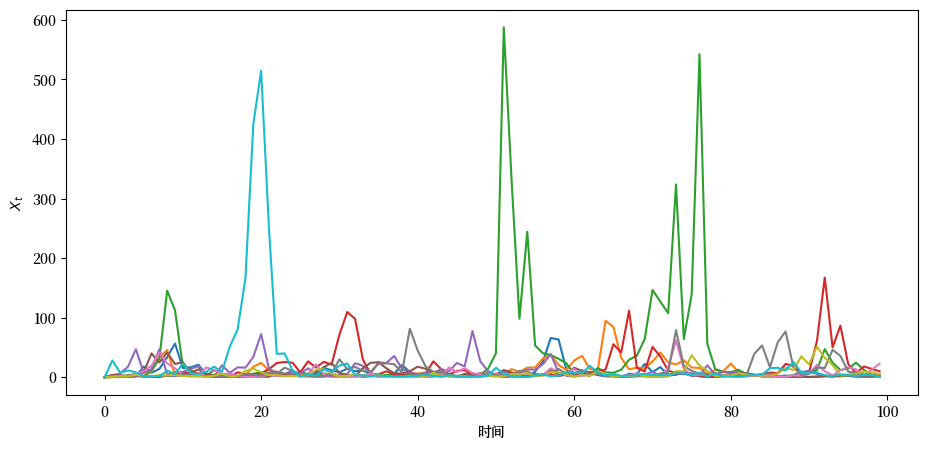

In [5]:
μ = -0.5
σ = 1.0

def kesten_ts(ts_length=100):
    x = np.zeros(ts_length)
    for t in range(ts_length-1):
        a = np.exp(μ + σ * np.random.randn())
        b = np.exp(np.random.randn())
        x[t+1] = a * x[t] + b
    return x

fig, ax = plt.subplots()

num_paths = 10
np.random.seed(12)

for i in range(num_paths):
    ax.plot(kesten_ts())

ax.set(xlabel='时间', ylabel='$X_t$')
plt.show()

## 应用：企业动态

正如我们在{doc}`关于重尾的讲座 <intro:heavy_tails>`中提到的，对于收入或就业等常见的企业规模衡量指标，美国企业规模分布表现出帕累托尾的特征（参见，例如，{cite}`axtell2001zipf`，{cite}`gabaix2016power`）。

让我们尝试运用Kesten--Goldie定理来解释这个相当有趣的事实。

### Gibrat定律

多年前，Robert Gibrat {cite}`gibrat1931inegalites`提出假设，认为企业规模按照一个简单的规则演化，即下一期规模与当前规模成比例。

这一假设现在被称为[Gibrat比例增长定律](https://en.wikipedia.org/wiki/Gibrat%27s_law)。

我们可以通过以下方式表达这一观点：企业规模的适当衡量指标$s_t$满足

```{math}
:label: firm_dynam_gb

\frac{s_{t+1}}{s_t} = a_{t+1}
```

其中$\{a_t\}$是某个正的独立同分布序列。

Gibrat定律的一个含意是，单个企业的增长率不依赖于它们的规模。

然而，在过去几十年里，文献中积累了很多与Gibrat定律相矛盾的研究。

例如，通常发现，平均而言：

1. 小企业比大企业增长更快（参见，例如，{cite}`evans1987relationship`和{cite}`hall1987relationship`），且
1. 小企业的增长率比大企业更不稳定{cite}`dunne1989growth`。

另一方面，研究发现Gibrat定律通常对大企业是一个合理的近似{cite}`evans1987relationship`。

我们可以通过修改{eq}`firm_dynam_gb`为以下形式来适应这些实证结果：

```{math}
:label: firm_dynam

s_{t+1} = a_{t+1} s_t + b_{t+1}
```

其中$\{a_t\}$和$\{b_t\}$都是独立同分布的，且相互独立。

在练习中，你需要证明{eq}`firm_dynam`中的Gibrat定律比{eq}`firm_dynam_gb`中的更符合上述实证结果。

### 重尾

那么这与帕累托尾有什么关系？

答案是{eq}`firm_dynam`是一个Kesten过程。

如果Kesten--Goldie定理的条件满足，那么可以预测企业规模分布会呈现重尾特征 --- 这正是我们在数据中看到的。

在下面的练习中，我们会进一步探讨这个想法，推广企业规模动态模型并检验相应的秩-规模图。

我们还将说明为什么帕累托尾的发现对定量分析很重要。

## 练习

```{exercise}
:label: kp_ex1

使用{eq}`garch11v`--{eq}`garch11r`中的GARCH(1, 1)过程模拟并绘制15年的日收益率（假设每年有250个工作日）。

设$\xi_t$和$\zeta_t$为独立的标准正态分布。

设$\alpha_0 = 0.00001, \alpha_1 = 0.1, \beta = 0.9$和$\sigma_0 = 0$。

与{ref}`上文所示的 <ndcode>`纳斯达克综合指数收益率进行直观对比。

虽然时间路径不同，但应能观察到高波动率的爆发。
```


```{solution-start} kp_ex1
:class: dropdown
```

这是一种解答：

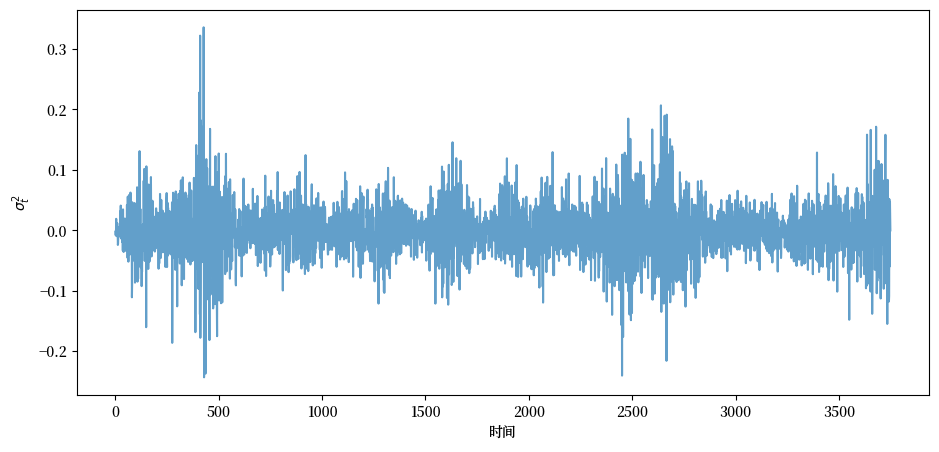

In [6]:
α_0 = 1e-5
α_1 = 0.1
β = 0.9

years = 15
days = years * 250

def garch_ts(ts_length=days):
    σ2 = 0
    r = np.zeros(ts_length)
    for t in range(ts_length-1):
        ξ = np.random.randn()
        σ2 = α_0 + σ2 * (α_1 * ξ**2 + β)
        r[t] = np.sqrt(σ2) * np.random.randn()
    return r

fig, ax = plt.subplots()

np.random.seed(12)

ax.plot(garch_ts(), alpha=0.7)

ax.set(xlabel='时间', ylabel='$\\sigma_t^2$')
plt.show()

```{solution-end}
```

```{exercise}
:label: kp_ex2

在我们关于企业动态的讨论中，认为{eq}`firm_dynam`比{eq}`firm_dynam_gb`中的Gibrat定律更符合实证文献。

（实证文献在{eq}`firm_dynam`之前刚刚进行了回顾。）

在什么意义上这是正确的（或错误的）？
```

```{solution-start} kp_ex2
:class: dropdown
```

实证研究结果是：

1. 小企业比大企业增长更快，且
1. 小企业的增长率比大企业更不稳定。

此外，相比小企业，Gibrat定律通常被发现对于大企业而言是一个合理的近似。

这个说法是指：{eq}`firm_dynam`中的动态比Gibrat定律更符合要点1-2。

要理解原因，我们将{eq}`firm_dynam`重写为增长动态的形式：

```{math}
:label: firm_dynam_2

\frac{s_{t+1}}{s_t} = a_{t+1} + \frac{b_{t+1}}{s_t}
```

给定$s_t = s$，企业增长率的均值和方差为：

$$
\mathbb E a
+ \frac{\mathbb E b}{s}
\quad \text{和} \quad
\mathbb V a
+ \frac{\mathbb V b}{s^2}
$$

这两者都随着企业规模$s$的增大而下降，与数据所显示的一致。

此外，当$s_t$变大时，动态定律{eq}`firm_dynam_2`显然趋近于Gibrat定律{eq}`firm_dynam_gb`。

```{solution-end}
```

```{exercise}
:label: kp_ex3

考虑如{eq}`kesproc`中给出的任意Kesten过程。

假设$\{a_t\}$是对数正态分布，参数为$(\mu, \sigma)$。

换句话说，当$Z$是标准正态分布时，每个$a_t$与$\exp(\mu + \sigma Z)$具有相同的分布。

进一步假设$\mathbb E \eta_t^r < \infty$对所有$r > 0$成立，例如，当$\eta_t$也是对数正态分布时，这一条件成立。

证明：当且仅当$\mu < 0$时，Kesten--Goldie定理的条件被满足。

并求出使Kesten--Goldie条件成立的$\alpha$值。
```

```{solution-start} kp_ex3
:class: dropdown
```

因为$a_t$有密度函数，所以它是非算术的。

由于$a_t$与$a = \exp(\mu + \sigma Z)$具有相同的密度函数（当$Z$是标准正态分布时），我们有：

$$
\mathbb E \ln a_t = \mathbb E (\mu + \sigma Z) = \mu,
$$

且由于$\eta_t$具有所有阶的有限矩，平稳性条件成立当且仅当$\mu < 0$。

给定对数正态分布的性质（它具有所有阶的有限矩），唯一需要验证的另一个条件是存在一个正常数$\alpha$，使得$\mathbb E a_t^\alpha = 1$。

这一条件等价于：

$$
\exp \left( \alpha \mu + \frac{\alpha^2 \sigma^2}{2} \right) = 1.
$$

解这个方程求出$\alpha$，可得$\alpha = -2\mu / \sigma^2$。

```{solution-end}
```


```{exercise-start}
:label: kp_ex4
```

在如{eq}`firm_dynam`中所述的企业动态模型中，的一个不现实方面是它忽略了企业的进入和退出。

在任何时期和任何市场中，我们都能观察到大量企业进入和退出市场。

关于这个问题的实证讨论可以在Hugo Hopenhayn {cite}`hopenhayn1992entry`的一篇著名论文中找到。

在这篇论文中，Hopenhayn构建了一个包含企业利润最大化和市场出清数量、工资及价格的进入退出模型。

在他的模型中，当进入企业数量等于退出企业数量时，便达到了平稳均衡。

在这种背景下，企业动态可以表示为：

```{math}
:label: firm_dynam_ee

s_{t+1} = e_{t+1} \mathbb{1}\{s_t < \bar s\} +
(a_{t+1} s_t + b_{t+1}) \mathbb{1}\{s_t \geq \bar s\}
```

其中：

* 状态变量$s_t$代表生产率（这是产出和企业规模的代理变量），
* 独立同分布序列$\{ e_t \}$被视为新进入企业的生产率样本值，且
* 变量$\bar s$是一个被视为给定的阈值，尽管它在Hopenhayn的模型中是内生的。

{eq}`firm_dynam_ee`背后的思想是，只要企业的生产率$s_t$保持在$\bar s$或在$\bar s$以上，这些企业就可以留在市场中。

* 在这种情况下，它们的生产率根据{eq}`firm_dynam`更新。

当企业的生产率$s_t$低于$\bar s$时，企业会选择退出。

* 在这种情况下，它们被生产率$e_{t+1}$的新企业替代。

关于动态特性我们能得出什么结论？

虽然{eq}`firm_dynam_ee`不是Kesten过程，但当$s_t$很大时，它的更新方式与Kesten过程相同。

所以，也许它的平稳分布仍然有帕累托尾？

你的任务是通过模拟和秩-规模图来研究这个问题。

方法是：

1. 选定很大的$M$和$T$，生成$M$个$s_T$的抽取样本；
1. 将结果中最大的1,000个抽取样本绘制成秩-规模图。

（当$T$很大时，$s_T$的分布将接近于平稳分布。）

在这个模拟中，假设：

* $a_t, b_t$和$e_t$都是对数正态分布，
* 参数为：

In [7]:
μ_a = -0.5        # a的位置参数
σ_a = 0.1         # a的尺度参数
μ_b = 0.0         # b的位置参数
σ_b = 0.5         # b的尺度参数
μ_e = 0.0         # e的位置参数
σ_e = 0.5         # e的尺度参数
s_bar = 1.0       # 阈值
T = 500           # 抽样日期
M = 1_000_000     # 企业数量
s_init = 1.0      # 每个企业的初始条件

```{exercise-end}
```

```{solution-start} kp_ex4
:class: dropdown
```

这是一种答案。
首先生成观测值：

In [8]:
from numba import jit, prange
from numpy.random import randn


@jit(parallel=True)
def generate_draws(μ_a=-0.5,
                   σ_a=0.1,
                   μ_b=0.0,
                   σ_b=0.5,
                   μ_e=0.0,
                   σ_e=0.5,
                   s_bar=1.0,
                   T=500,
                   M=1_000_000,
                   s_init=1.0):

    draws = np.empty(M)
    for m in prange(M):
        s = s_init
        for t in range(T):
            if s < s_bar:
                new_s = np.exp(μ_e + σ_e *  randn())
            else:
                a = np.exp(μ_a + σ_a * randn())
                b = np.exp(μ_b + σ_b * randn())
                new_s = a * s + b
            s = new_s
        draws[m] = s

    return draws

data = generate_draws()

现在来生成秩-规模图：

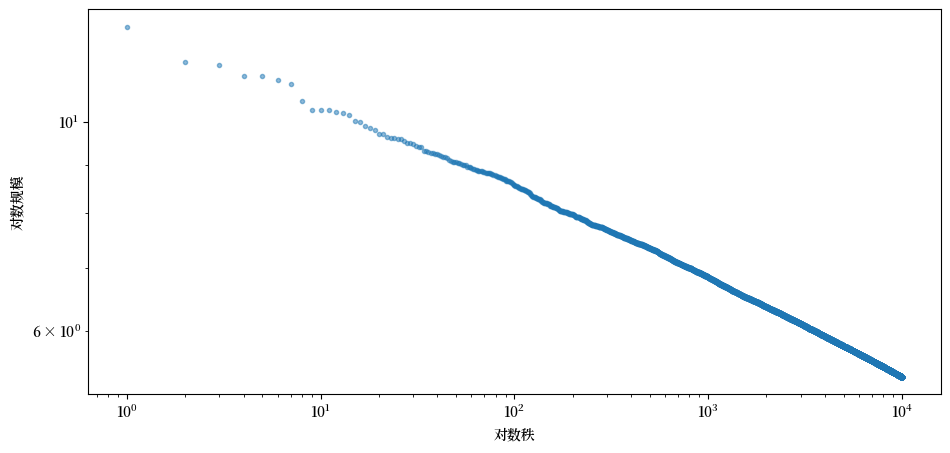

In [9]:
fig, ax = plt.subplots()

rank_data, size_data = qe.rank_size(data, c=0.01)
ax.loglog(rank_data, size_data, 'o', markersize=3.0, alpha=0.5)
ax.set_xlabel("对数秩")
ax.set_ylabel("对数规模")

plt.show()

该图呈现出一条直线，符合帕累托尾的特性。

```{solution-end}
```